In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import shapefile



/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [8]:
data_dir = '/Users/gbromley/data/CRU/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'tmp/cru_ts3.24.1901.2015.tmp.dat.nc'
nc_temp = xr.open_dataset(data_dir+temp_file)


In [116]:
t2m = nc_temp['t2m']

KeyError: 't2m'

In [8]:
#t_season='AMJ'
#t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2015-12-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38

#ggw_lat,ggw_lon = 48.18, -106.635

In [ ]:
t2m_slice=t2m.sel(time=slice(start_year,end_year))

In [9]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))


#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))

#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_30.groupby('time.season').mean(dim='time')

In [10]:
t2m_slice = t2m_slice.groupby('time.season').apply(lambda x: x.groupby('time.year').mean(dim='time'))

In [13]:
anom = t2m_slice - t2m_clim_months_avg

In [ ]:
anom.season

In [11]:
#create 2d structure to hold slope
season = ['DJF','JJA','MAM','SON']
lat = t2m.lat
lon=t2m.lon
spatial_trend = xr.DataArray(np.random.rand(4,54,76),coords=[season,lat,lon],dims=['season','lat','lon'])
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'



slope_scipy = t2m.isel(time=1).copy(deep=True)
#create 2d structure to hold pvalues
pvalues= t2m.isel(time=1).copy(deep=True)
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [ ]:
spatial_trend

In [14]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(anom.year))
corr_vals = sm.add_constant(corr_vals)
for k in np.arange(0,4):
    for i in np.arange(0,len(anom['lat'])):
        for j in np.arange(0,len(anom['lon'])):
            series = anom[k,i,j,:]
            model = sm.OLS(series.values,corr_vals)
            #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
            results = model.fit()
            slope = results.params[1]
            #t_value = ((slope - 0.02)/results.bse[1])
            #p_value = stats.t.cdf(t_value, results.df_resid)
           # p_value = stats.t.sf(results.tvalues[0], results.df_resid)
            spatial_trend[k,i,j]=slope*10
            #slope_scipy[i,j] = slope_2*10
            #pvalues[i,j]= p_value
            #print(i)

In [ ]:
pvals = pvalues.where(pvalues.values < 0.05)

In [ ]:
spatial_trend[1,:,:].plot()

In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_temp_tobias'+t_season+'_'+'1970'+'.nc')

In [ ]:
pvalues.to_dataset().to_netcdf(t_season+'_1970_pvalues.nc')

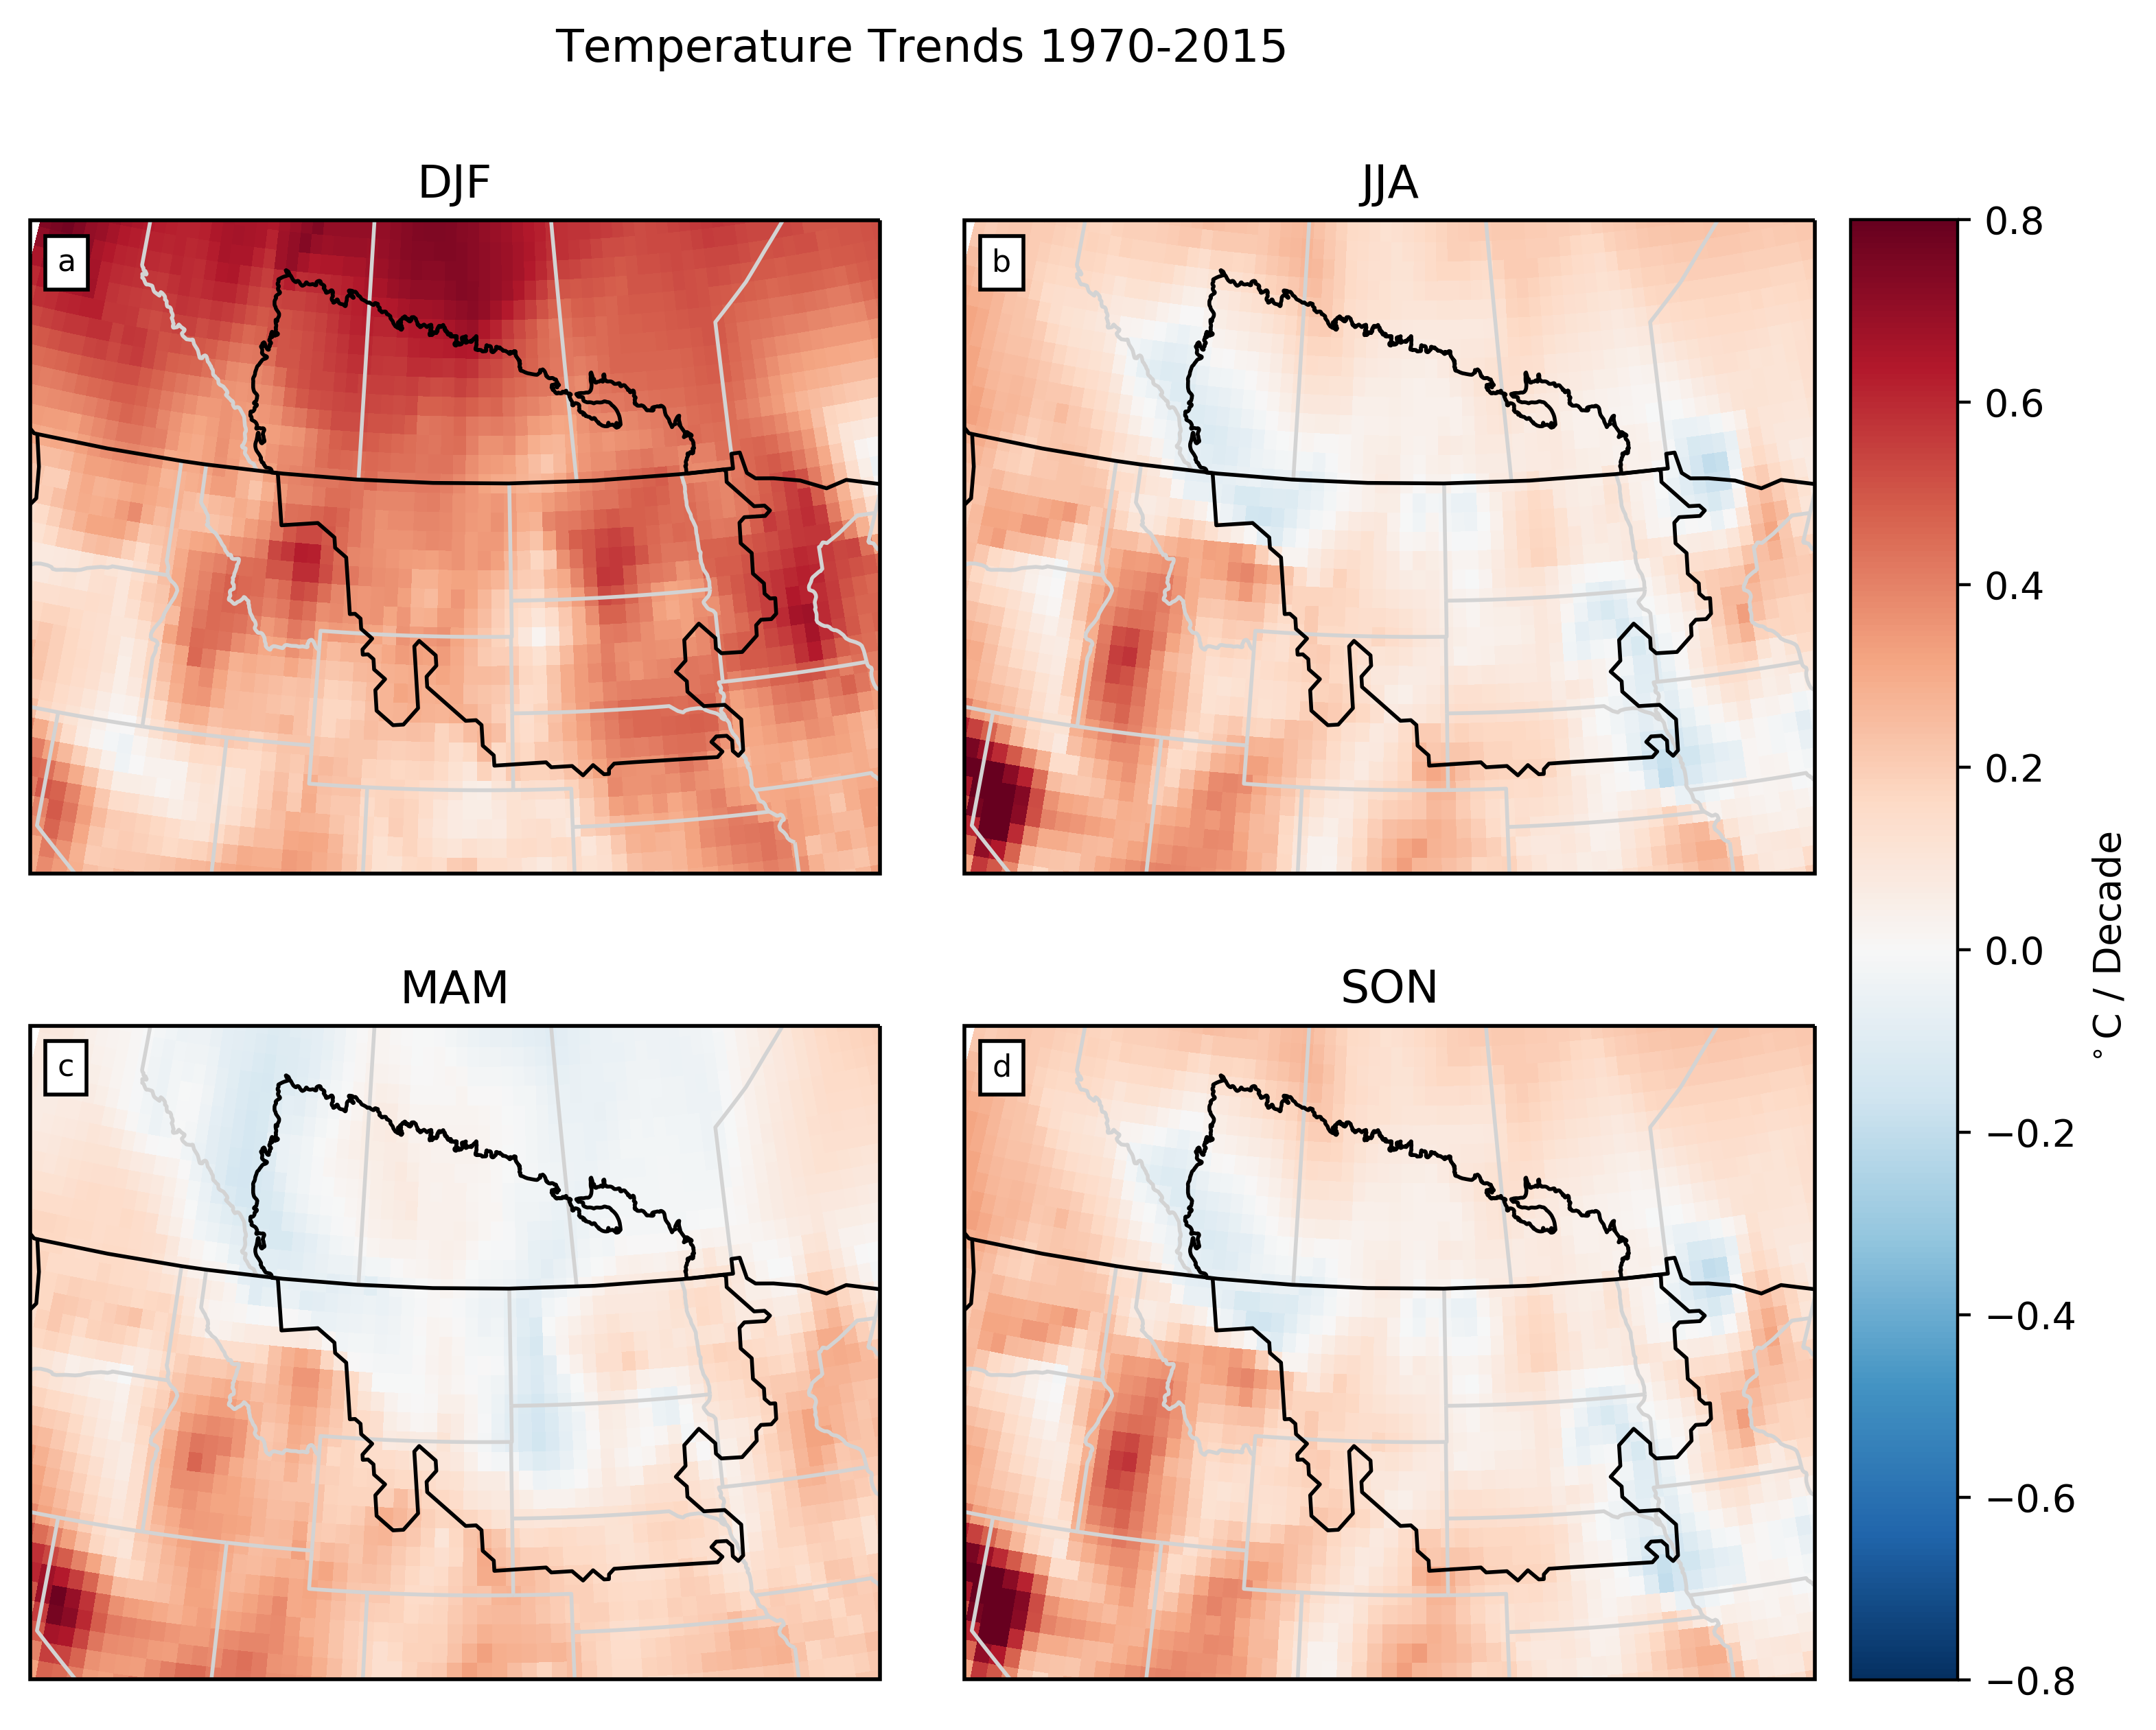

In [62]:
#create figure
fig = plt.figure(1,figsize=(13,7), dpi=400.0)
#create projection
projection = ccrs.LambertConformal(central_longitude=-105,central_latitude=45,standard_parallels=[50,40])
ax1 = plt.subplot(2,2,1, projection = projection)

cb = plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[0,:,:].values,transform=ccrs.PlateCarree(),vmin=-0.8, vmax=0.8, cmap='RdBu_r')
#pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
ax1.add_feature(shape_feature)
ax1.title.set_text('DJF')
at = AnchoredText("a",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax1.add_artist(at)

ax2 = plt.subplot(2,2,2, projection = projection)
ax2.set_title('JJA')
plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[1,:,:].values,transform=ccrs.PlateCarree(),vmin=-0.8, vmax=0.8, cmap='RdBu_r')

ax2.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax2.add_feature(states_provinces, edgecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(shape_feature)
bt = AnchoredText("b",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax2.add_artist(bt)
#ax2.title.set_visible(False)

ax3 = plt.subplot(2,2,3, projection = projection)
ax3.set_title('MAM')
plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[2,:,:].values,transform=ccrs.PlateCarree(),vmin=-0.8, vmax=0.8, cmap='RdBu_r')
#ax = plt.axes(projection=ccrs.LambertConformal())
#pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax3.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax3.add_feature(states_provinces, edgecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS)
ax3.add_feature(shape_feature)
ct = AnchoredText("c",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax3.add_artist(ct)


ax4 = plt.subplot(2,2,4, projection = projection)
ax4.set_title('SON')
plt.pcolormesh(spatial_trend.lon,spatial_trend.lat,spatial_trend[1,:,:].values,transform=ccrs.PlateCarree(),vmin=-0.8, vmax=0.8, cmap='RdBu_r')
#ax = plt.axes(projection=ccrs.LambertConformal())
#pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax4.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax4.add_feature(states_provinces, edgecolor='lightgray')
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS)
ax4.add_feature(shape_feature)
dt = AnchoredText("d",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax4.add_artist(dt)
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.25,right=0.75,hspace=0.1,wspace=0.1)
fig.suptitle('Temperature Trends 1970-2015')
cax = fig.add_axes((0.76, 0.12, 0.03, 0.76))
col_bar = fig.colorbar(cb,cax=cax)
col_bar.set_label('$^\circ$C / Decade',fontsize=10)

#plt.tight_layout()
plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/four_panel_temp.png',bbox_inches='tight')
plt.show()


In [52]:
ax2.get_position()

Bbox([[0.5119047619047619, 0.5395088492229407], [0.75, 0.8795387698246783]])

In [53]:
ax4.get_position()

Bbox([[0.5119047619047619, 0.12046123017532179], [0.75, 0.4604911507770593]])

In [55]:
0.12+0.54

0.66

In [115]:

import geopandas
from rasterio import features
from affine import Affine
import numpy as np
import xarray
import matplotlib.pyplot as plt
%matplotlib inline

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xarray.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

shape = geopandas.read_file('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp')

test = rasterize(shape.geometry,t2m.coords,latitude='lat',longitude='lon')

test.to_netcdf('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/ngp_mask.nc')

In [109]:
shape.geometry

0    POLYGON ((-113.198629670036 48.9952539435385, ...
Name: geometry, dtype: object

In [104]:
test = shape.convex_hull

TypeError: '<' not supported between instances of 'Polygon' and 'float'

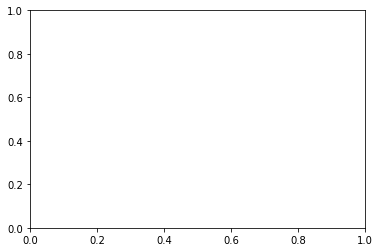